<a href="https://colab.research.google.com/github/Ki6an/Machine_Learning_Projects/blob/master/Music%20Gen%20(final)/Music_Gen(upshot).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# all the data are imported from drive 
import glob
import pickle
import numpy as np
import tensorflow as tf
import tqdm 
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [147]:
def get_notes():
    
    """ Extracts all notes and chords from midi files in the ./midi_songs 
    directory and creates a file with all notes in string format"""
    
    notes = []

    for file in glob.glob("/content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('/content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [148]:
# preaparing the data to feed into the rnn
notes = get_notes()
vocab = sorted(set(item for item in notes))
vocab_size = len(vocab)
notes_to_int = dict((note, number) for number, note in enumerate(vocab))
notes = get_notes()

idx2char = np.array(vocab)

def vectorize_string(notes):
  return np.array([notes_to_int[x] for x in notes])

vectorized_songs = vectorize_string(notes)
len(vectorized_songs), notes[5]

Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_se1.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_esp6.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_esp5.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_esp3.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_esp4.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_esp2.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_se5.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_se4.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_se3.mid
Parsing /content/drive/My Drive/Machine Learning /Projects/Music_Gen(upshot)/dataset/alb_se2.mid
Parsing /content/drive/My

(173581, '5.9.0')

In [161]:
def get_batch(vectorized_songs, seq_length, batch_size):

  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)


  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)
x_batch.shape, y_batch.shape

((1, 5), (1, 5))

In [162]:
# building the model
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

  model = Sequential()

  model.add(Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))

  model.add(LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',
                   recurrent_activation='sigmoid',stateful=True))
  
  model.add(Dense(vocab_size))     

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (32, None, 256)           97280     
_________________________________________________________________
lstm_15 (LSTM)               (32, None, 1024)          5246976   
_________________________________________________________________
dense_15 (Dense)             (32, None, 380)           389500    
Total params: 5,733,756
Trainable params: 5,733,756
Non-trainable params: 0
_________________________________________________________________


In [163]:

# for plotting 

import time
import matplotlib.pyplot as plt

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [176]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 4000  # Increase this to train longer [use 4k]
batch_size = 32                 # Experiment between 1 and 64
seq_length =100                 # Experiment between 50 and 500
learning_rate = 5e-3            # Experiment between 1e-5 and 1e-1

# Model parameters: 
embedding_dim = 256 
rnn_units = 1024                # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [177]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) 
  return loss

@tf.function
def train_step(x, y): 

  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model(x)
  
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################


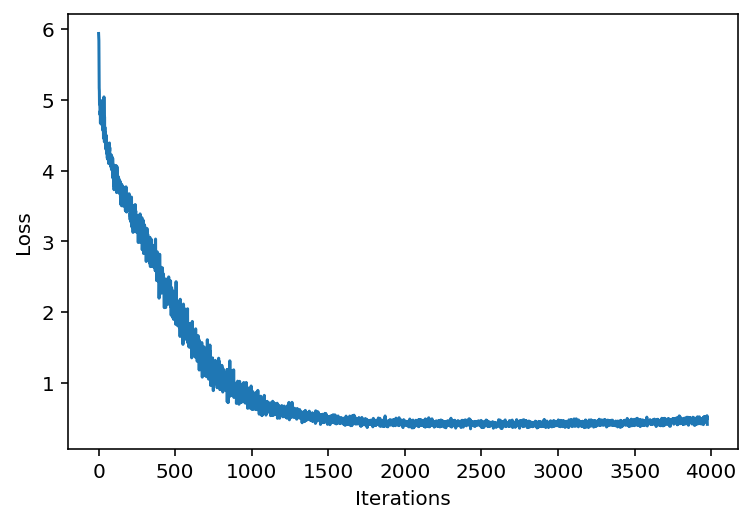

100%|██████████| 4000/4000 [03:07<00:00, 21.39it/s]


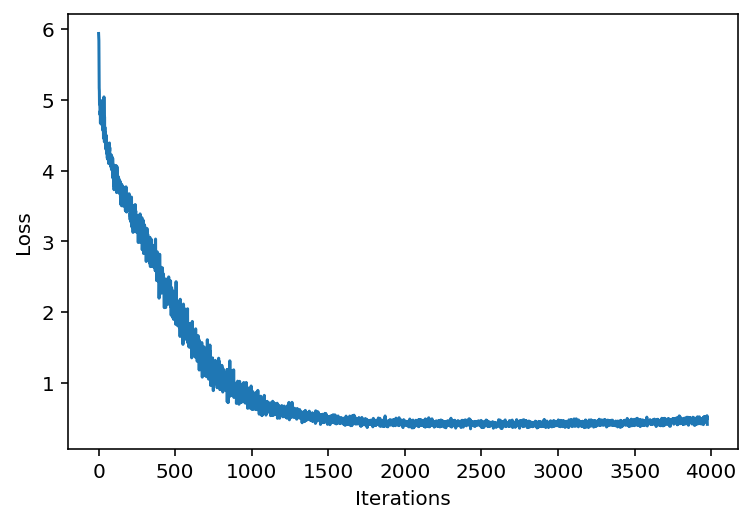

In [178]:
history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [180]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (1, None, 256)            97280     
_________________________________________________________________
lstm_20 (LSTM)               (1, None, 1024)           5246976   
_________________________________________________________________
dense_20 (Dense)             (1, None, 380)            389500    
Total params: 5,733,756
Trainable params: 5,733,756
Non-trainable params: 0
_________________________________________________________________


In [181]:
vectorized_songs[5]

191

In [187]:
def generate_text(model, start_position, generation_length=500):
 
  input_eval = vectorized_songs[start_position:]
 
  input_eval = tf.expand_dims(input_eval, 0)
 
  # Empty string to store our results
  text_generated = []
  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()
 
  for i in tqdm(range(generation_length)):
 
      predictions = model(input_eval)
      
      predictions = tf.squeeze(predictions, 0)
 
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
  
      input_eval = tf.expand_dims([predicted_id], 0)

      result = idx2char[predicted_id]
      
      text_generated.append(result)
    #   text_generated.append(',')
    
  return text_generated
      
#       input_eval = tf.expand_dims([predicted_id], 0)
      
#       all_val.append(predicted_id)
 

#   return np.concatenate((vectorized_songs[start_position], all_val), axis=None)

In [188]:
generated_values = generate_text(model, start_position= 88, generation_length=500)
generated_values[:10]

100%|██████████| 500/500 [00:15<00:00, 31.59it/s]


['9.0', 'E4', '5.9.0', 'D4', 'C4', '5.9.0', 'D4', 'E4', '0.5', '9.0']

In [189]:
def create_midi(prediction_output):
    
    """ Converts the output from the prediction to notes and create a midi file
        from the notes """
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.SnareDrum()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.SnareDrum()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='first_mel.mid')

    midi_stream.show('midi')

In [190]:
type(generated_values), len(generated_values)

create_midi(generated_values)

# type(predicted_output)